In [4]:
#from keras.applications import VGG16
from cbds.deeplearning.models import vgg16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model

def vgg16_model(trainable=True):
    base_model = vgg16(input_shape=(75,75,3), include_top=False, weights="imagenet", )
    for layer in base_model.layers:
        layer.trainable = True
    
    last_conv_layer = base_model.get_layer("block4_conv3")
    x = GlobalAveragePooling2D()(last_conv_layer.output)
    x = Dense(512, activation="relu")(x)  
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.25)(x)
    predictions = Dense(1, activation="sigmoid")(x)
    return Model(base_model.input, predictions)



model = vgg16_model(False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_batch1 (BatchNormaliz (None, 75, 75, 64)        256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_batch2 (BatchNormaliz (None, 75, 75, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
__________

In [7]:
from Datasets import Datasets

dataset_name = "Bradbury"
dataset = Datasets.datasets()[dataset_name]

In [8]:
from keras.applications.xception import preprocess_input
import numpy as np

# Add preprocessing
train_images = dataset[0].images
train_labels  = dataset[0].labels

test_images = dataset[1].images
test_labels = dataset[1].labels

validation_images = dataset[2].images
validation_labels = dataset[2].labels

In [4]:
train_images.max(), train_images.min()

(1.0000001, 0.010416664)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from ProjectPaths import ProjectPaths

In [10]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range = 0.1,
    zoom_range = 0.3,
    shear_range = 0.15,                                
    #brightness_range = [0.9, 1.1],
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator()


In [11]:
batch_size = 64

train_generator = data_generator.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [ ]:
from keras.callbacks import LearningRateScheduler

def schedule_lr(epoch):
    return 0.01

lrCallback = LearningRateScheduler(schedule_lr)

In [5]:
from keras.optimizers import SGD

epochs = 100
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [6]:
from PerformanceMetrics import PerformanceMetrics

model.compile(optimizer=sgd, loss='binary_crossentropy',
                  metrics=['accuracy', PerformanceMetrics.precision,
                           PerformanceMetrics.recall, PerformanceMetrics.fmeasure])

In [12]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping




model_name = "vgg16_3t_wmp_wr_batch_norm_{}".format(dataset_name)

checkpoint_dir = ProjectPaths.instance().checkpoint_dir_for(model_name, batch_size, epochs)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

file_in_checkpoint_dir = ProjectPaths.instance().file_in_checkpoint_dir(model_name, batch_size,
                                                                 epochs,  model_name +
                                                                 "__{epoch:02d}_{val_acc:.2f}.hdf5")

early_stopping_callback = EarlyStopping(patience=5)
model_checkpoint_callback = ModelCheckpoint(file_in_checkpoint_dir, monitor='val_acc', verbose=True,
                                                save_weights_only=True,
                                                save_best_only=True)

log_dir = os.path.join(ProjectPaths.instance().log_dir, model_name)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,  write_graph=False, write_images=False)


H = model.fit_generator(train_generator,
                    steps_per_epoch=len(train_labels) // batch_size, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
                    validation_data=test_generator,
                    validation_steps=len(test_labels) // batch_size)

Epoch 1/100
496/496 [==============================] - 44s 89ms/step - loss: 0.3239 - acc: 0.8612 - precision: 0.8415 - recall: 0.8939 - fmeasure: 0.8643 - val_loss: 0.2090 - val_acc: 0.9168 - val_precision: 0.8802 - val_recall: 0.9636 - val_fmeasure: 0.9188

Epoch 00001: val_acc improved from -inf to 0.91683, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_3t_wmp_wr_batch_norm_Bradbury_2019-03-29_64_100/vgg16_3t_wmp_wr_batch_norm_Bradbury__01_0.92.hdf5
Epoch 2/100
496/496 [==============================] - 44s 90ms/step - loss: 0.2328 - acc: 0.9031 - precision: 0.8925 - recall: 0.9195 - fmeasure: 0.9036 - val_loss: 0.1707 - val_acc: 0.9314 - val_precision: 0.9042 - val_recall: 0.9646 - val_fmeasure: 0.9322

Epoch 00002: val_acc improved from 0.91683 to 0.93144, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_3t_wmp_wr_batch_norm_Bradbury_2019-03-29_64_100/vgg16_3t_wmp_wr_batch_norm_Bradbury__02_0.93.hdf5
Epoch 3/100
496/496 [========================

496/496 [==============================] - 42s 85ms/step - loss: 0.1268 - acc: 0.9490 - precision: 0.9478 - recall: 0.9523 - fmeasure: 0.9486 - val_loss: 0.0932 - val_acc: 0.9642 - val_precision: 0.9500 - val_recall: 0.9787 - val_fmeasure: 0.9634

Epoch 00020: val_acc did not improve from 0.96649
Epoch 21/100
496/496 [==============================] - 42s 85ms/step - loss: 0.1241 - acc: 0.9489 - precision: 0.9488 - recall: 0.9506 - fmeasure: 0.9483 - val_loss: 0.0911 - val_acc: 0.9644 - val_precision: 0.9521 - val_recall: 0.9772 - val_fmeasure: 0.9638

Epoch 00021: val_acc did not improve from 0.96649
Epoch 22/100
496/496 [==============================] - 42s 85ms/step - loss: 0.1226 - acc: 0.9506 - precision: 0.9473 - recall: 0.9552 - fmeasure: 0.9498 - val_loss: 0.0899 - val_acc: 0.9647 - val_precision: 0.9535 - val_recall: 0.9763 - val_fmeasure: 0.9641

Epoch 00022: val_acc did not improve from 0.96649
Epoch 23/100
496/496 [==============================] - 42s 85ms/step - loss: 0.

496/496 [==============================] - 43s 86ms/step - loss: 0.1004 - acc: 0.9602 - precision: 0.9605 - recall: 0.9610 - fmeasure: 0.9598 - val_loss: 0.0757 - val_acc: 0.9716 - val_precision: 0.9599 - val_recall: 0.9836 - val_fmeasure: 0.9711

Epoch 00043: val_acc did not improve from 0.97288
Epoch 44/100
496/496 [==============================] - 43s 86ms/step - loss: 0.0969 - acc: 0.9617 - precision: 0.9617 - recall: 0.9620 - fmeasure: 0.9609 - val_loss: 0.0724 - val_acc: 0.9724 - val_precision: 0.9622 - val_recall: 0.9825 - val_fmeasure: 0.9718

Epoch 00044: val_acc did not improve from 0.97288
Epoch 45/100
496/496 [==============================] - 43s 86ms/step - loss: 0.0977 - acc: 0.9605 - precision: 0.9605 - recall: 0.9613 - fmeasure: 0.9600 - val_loss: 0.0741 - val_acc: 0.9726 - val_precision: 0.9627 - val_recall: 0.9826 - val_fmeasure: 0.9721

Epoch 00045: val_acc did not improve from 0.97288
Epoch 46/100
496/496 [==============================] - 42s 86ms/step - loss: 0.

Text(0.5, 0, 'Epochs')

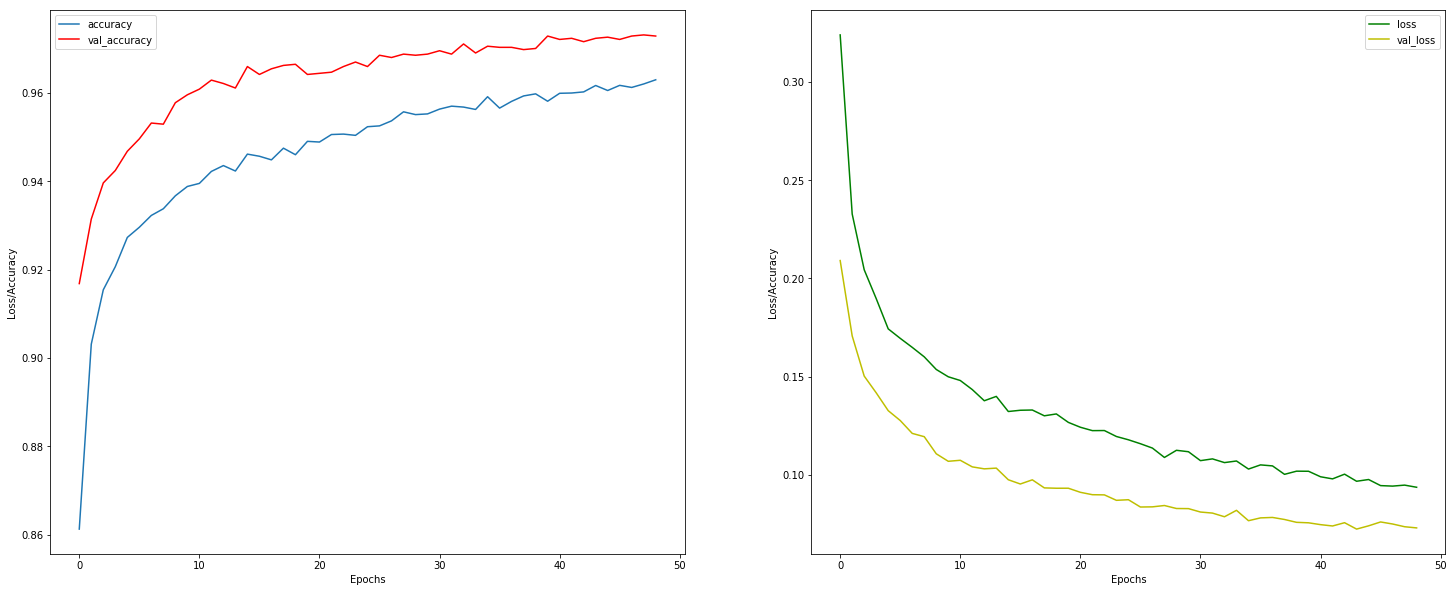

In [13]:
epochs_ran = len(H.history["loss"])

_, ax = plt.subplots(1,2, figsize=(25, 10))
ax[0].plot(np.arange(0, epochs_ran), H.history["acc"], label="accuracy")
ax[0].plot(np.arange(0, epochs_ran), H.history["val_acc"], label="val_accuracy", color="r")
ax[1].plot(np.arange(0, epochs_ran), H.history["loss"], label="loss", color="g")
ax[1].plot(np.arange(0, epochs_ran), H.history["val_loss"], label="val_loss", color="y")
ax[0].legend()
ax[1].legend()

ax[0].set_ylabel("Loss/Accuracy")
ax[0].set_xlabel("Epochs")

ax[1].set_ylabel("Loss/Accuracy")
ax[1].set_xlabel("Epochs")


In [12]:
# load best model
from keras.models import load_model

#model.load_weights(r"/media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_3t_wmp_wr_batch_norm_Bradbury_2019-01-18_64_100/vgg16_3t_wmp_wr_batch_norm_Bradbury__10_0.97.hdf5")
model.load_weights(r"/media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_3t_wmp_wr_batch_norm_Bradbury_2019-01-18_64_100/vgg16_3t_wmp_wr_batch_norm_Bradbury__12_0.97.hdf5")

In [14]:
import pandas as pd

train_eval = model.evaluate(train_images, train_labels, batch_size)
test_eval = model.evaluate(test_images, test_labels, batch_size)
validation_eval = model.evaluate(validation_images, validation_labels, batch_size)

np_model_evaluations = np.array([train_eval, test_eval, validation_eval])

evaluations = pd.DataFrame(np_model_evaluations, columns=model.metrics_names)
print(evaluations.head())

3973/3973 [==============================] - 2s 440us/step
       loss       acc  precision    recall  fmeasure
0  0.046085  0.982912   0.978770  0.987463  0.982826
1  0.072456  0.973068   0.962490  0.983947  0.972607
2  0.071262  0.972061   0.961631  0.983497  0.972039


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def find_optimal_cutoff(target, predicted):
   """ Find the optimal probability cutoff point for a classification model related to event rate
   Parameters
   ----------
   target : Matrix with dependent or target data, where rows are observations

   predicted : Matrix with predicted data, where rows are observations

   Returns
   -------
   list type, with optimal cutoff value

   """
   fpr, tpr, threshold = roc_curve(target, predicted)
   i = np.arange(len(tpr))
   roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
   roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

   return list(roc_t['threshold'])

In [16]:
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_images, batch_size)

In [17]:
cut_off = find_optimal_cutoff(test_labels, test_predictions)
cut_off

/home/tim/.virtualenvs/DeepSolaris/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.6499414443969727]

In [18]:
predicted_labels = test_predictions > cut_off
confusion_matrix(test_labels, predicted_labels)


array([[1965,   50],
       [  50, 1908]])

In [19]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2015
           1       0.97      0.97      0.97      1958

   micro avg       0.97      0.97      0.97      3973
   macro avg       0.97      0.97      0.97      3973
weighted avg       0.97      0.97      0.97      3973



# Aachen

In [20]:
ac_dataset = Datasets.datasets()["AcMüDüHo"]

train_images = ac_dataset[0].images
train_labels = ac_dataset[0].labels

test_images = ac_dataset[1].images
test_labels = ac_dataset[1].labels

validation_images = ac_dataset[2].images
validation_labels = ac_dataset[2].labels

eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(eval_images.shape, eval_labels.shape)

(3357, 75, 75, 3) (374, 75, 75, 3) (934, 75, 75, 3)
(4665, 75, 75, 3) (4665,)


In [21]:
eval_predictions = model.predict(eval_images, batch_size) > cut_off
confusion_matrix(eval_labels, eval_predictions)

array([[2267,   67],
       [ 850, 1481]])

In [22]:
from sklearn.metrics import classification_report

print(classification_report(eval_labels, eval_predictions))

              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83      2334
         1.0       0.96      0.64      0.76      2331

   micro avg       0.80      0.80      0.80      4665
   macro avg       0.84      0.80      0.80      4665
weighted avg       0.84      0.80      0.80      4665



# Fresno

In [23]:
fresno_dataset = Datasets.datasets()["Fresno"]

train_images = fresno_dataset[0].images
train_labels = fresno_dataset[0].labels

test_images = fresno_dataset[1].images
test_labels = fresno_dataset[1].labels

validation_images = fresno_dataset[2].images
validation_labels = fresno_dataset[2].labels

fresno_eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
fresno_eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(fresno_eval_images.shape, fresno_eval_labels.shape)

(3646, 75, 75, 3) (1022, 75, 75, 3) (1022, 75, 75, 3)
(5690, 75, 75, 3) (5690,)


In [24]:
fresno_eval_predictions = model.predict(fresno_eval_images, batch_size) > cut_off
confusion_matrix(fresno_eval_labels, fresno_eval_predictions)

array([[2801,   44],
       [  44, 2801]])

In [25]:
from sklearn.metrics import classification_report

print(classification_report(fresno_eval_labels, fresno_eval_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2845
           1       0.98      0.98      0.98      2845

   micro avg       0.98      0.98      0.98      5690
   macro avg       0.98      0.98      0.98      5690
weighted avg       0.98      0.98      0.98      5690



# Heerlen Annotated Dataset

In [26]:
deepsolaris_heerlen_images = np.load(os.path.join(ProjectPaths.instance().image_dir, "deepsolaris_heerlen.npy"))
deepsolaris_heerlen_labels = np.load(os.path.join(ProjectPaths.instance().image_dir, "deepsolaris_heerlen_labels.npy"))
deepsolaris_heerlen_images.shape, deepsolaris_heerlen_labels.shape

((15540, 75, 75, 3), (15540,))

In [27]:
deepsolaris_heerlen_images = deepsolaris_heerlen_images / 255

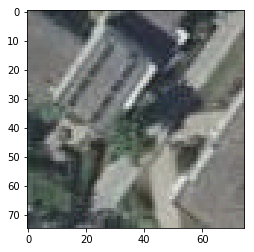

In [26]:
plt.imshow(deepsolaris_heerlen_images[0][:,:,::-1])

In [28]:
ds_heerlen_predictions = model.predict(deepsolaris_heerlen_images, batch_size) > cut_off
confusion_matrix(deepsolaris_heerlen_labels, ds_heerlen_predictions)

array([[9049, 2361],
       [1274, 2856]])

In [29]:
from sklearn.metrics import classification_report

print(classification_report(deepsolaris_heerlen_labels, ds_heerlen_predictions))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83     11410
           1       0.55      0.69      0.61      4130

   micro avg       0.77      0.77      0.77     15540
   macro avg       0.71      0.74      0.72     15540
weighted avg       0.79      0.77      0.77     15540



In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(deepsolaris_heerlen_labels, ds_heerlen_predictions)

0.7660875160875161

# Heerlen Preprocessing

Now we use the trained model to preprocess the images from Heerlen and see how well it performs.

In [26]:
heerlen_dir = os.path.join(ProjectPaths.instance().image_dir, "Heerlen75x75")
image_files = [os.path.join(heerlen_dir, filename) for filename in os.listdir(heerlen_dir) if filename.endswith("rgb_2016.tiff") or filename.endswith("rgb_2017.tiff")]
image_files = sorted(image_files)
image_files[0:10]

['/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/00071b0a-e436-441d-9739-9911833434aa_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/000fac0e-c102-4af4-8314-d3f53016d465_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/001707ad-b863-480e-8aa9-061b151ae49f_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/001ee372-4d98-406e-81fb-b07711f14887_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0021b36e-80c2-4bc8-ad88-7fcd6290f757_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0025fd83-1c7f-4154-9e88-6c321a41466d_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/002f4183-23f7-49a0-9a04-414adf0ba3cf_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/00304bff-a225-42bd-a269-e38331a21aa1_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0031b200-bb4d-4af0-9738-c816f1c03a27_rgb_2017

In [ ]:
len(image_files)

In [27]:
def create_dir(path):
    if os.path.exists(path):
        return
    os.makedirs(path)

In [29]:
preprocessed_dir = os.path.join(ProjectPaths.instance().image_dir, "Heerlen75x75_preprocessed")
positives_dir = os.path.join(preprocessed_dir, "Positives")
negatives_dir = os.path.join(preprocessed_dir, "Negatives")

create_dir(positives_dir)
create_dir(negatives_dir)


In [30]:
img = load_img(image_files[0])    
img_array = img_to_array(img).astype(np.uint8)
image_rescaled = rescale(img_array, 0.25 / 0.2, anti_aliasing=False)
image_rescaled.shape

height, width, _ = image_rescaled.shape
mY = height // 2
mX = width // 2
x1 = mX - 37
x2 = mX + 38
y1 = mY - 37
y2 = mY + 38

image_rescaled.shape, mX, mY, x1, x2, y1, y2, image_rescaled.min(), image_rescaled.max(), img_array.min(), img_array.max() 

NameError: name 'load_img' is not defined

In [ ]:
0.25/0.2

In [31]:
from keras.preprocessing.image import load_img, img_to_array 
from keras.applications.vgg16 import preprocess_input
from skimage.transform import rescale

def prepare_image(filename):
    img = load_img(filename)    
    img_array = img_to_array(img).astype(np.uint8)
    return img_array / 255
    #image_rescaled = rescale(img_array, 0.25 / 0.2, anti_aliasing=False)
    #height, width, _ = image_rescaled.shape
    #mY = height // 2
    #mX = width // 2
    #x1 = mX - 37
    #x2 = mX + 38
    #y1 = mY - 37
    #y2 = mY + 38
    #return image_rescaled[y1:y2,x1:x2, ::-1]

def image_generator(image_files, batch_size):
    batch = []
    for i, filename in enumerate(image_files):
        if i > 0 and (i % batch_size == 0):
            old_batch = batch
            batch = []
            yield np.array(old_batch)
        batch.append(prepare_image(filename))
    #if len(batch) > 0:
    #    repeat_last = len(batch) - batch_size
    #    repeated_images = [batch[-1] for i in range(repeat_last)]
    #   yield np.array(batch + repeated_images)

heerlen_image_generator = image_generator(image_files, batch_size)

In [ ]:
img = next(heerlen_image_generator)
img.shape

In [ ]:
img = load_img(image_files[0])

i = prepare_image(image_files[0])
img.size, i.shape
#plt.imshow(i)

Predict labels for the images in the source directory and write them to positive or negative directory based on the prediction

In [32]:
predictions = model.predict_generator(heerlen_image_generator, steps=len(image_files) // batch_size)

In [33]:
predictions = predictions.reshape(predictions.shape[0])
predictions.shape

(10560,)

In [34]:
(predictions > cut_off).sum(), (predictions <= cut_off).sum()

(4758, 5802)

In [35]:
from shutil import copyfile

positive_predictions = []
negative_predictions = []
for i, file_path in enumerate(image_files):        
    filename = os.path.basename(file_path)
    if i >= predictions.shape[0]:
        break
    
    prediction = predictions[i]    
    if prediction > cut_off:
        output_path = os.path.join(positives_dir, filename)
        positive_predictions.append(prediction)
    else:        
        output_path = os.path.join(negatives_dir, filename)
        negative_predictions.append(prediction)
    copyfile(file_path, output_path)

In [36]:
len(os.listdir(positives_dir)), len(os.listdir(negatives_dir))

(4758, 5802)

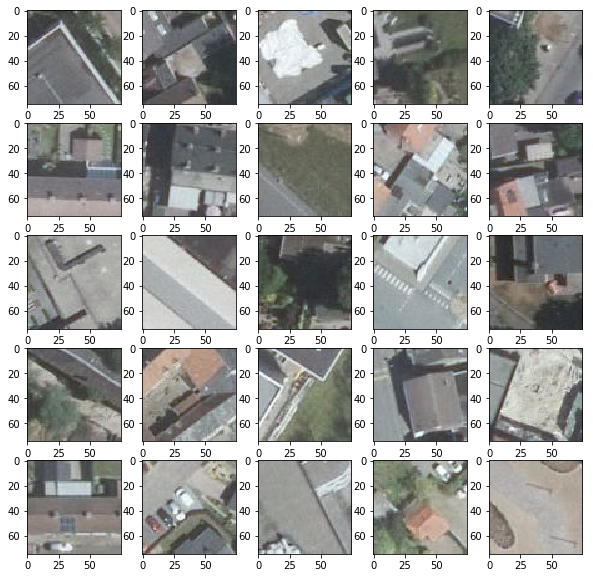

In [37]:
positive_images = [load_img(os.path.join(positives_dir, image)) for i, image in enumerate(os.listdir(positives_dir))]

_, ax = plt.subplots(5,5, figsize=(10,10))

j = 25
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(positive_images[j])     
        j += 1 


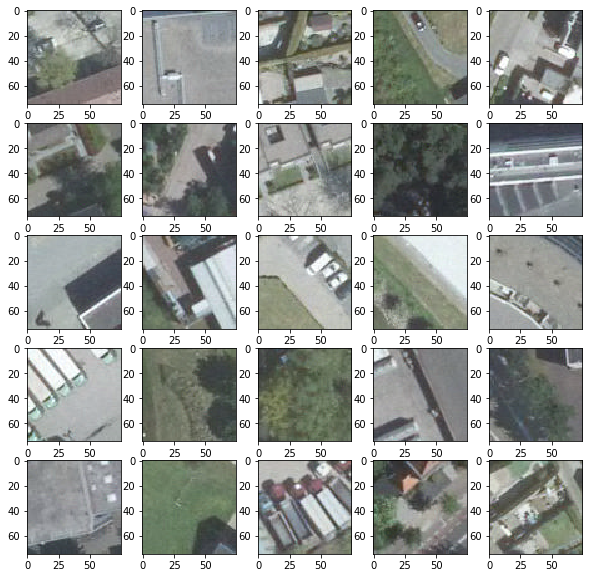

In [38]:
negative_images = [load_img(os.path.join(negatives_dir, image)) for i, image in enumerate(os.listdir(negatives_dir))]

_, ax = plt.subplots(5,5, figsize=(10,10))

j = 0
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(negative_images[j])     
        j += 1 


In [ ]:
negative_predictions[50:75]